In [3]:
#price and Everything

import warnings
from glob import glob

import pandas as pd
import seaborn as sns
from category_encoders import OneHotEncoder
from IPython.display import VimeoVideo
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge  # noqa F401
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted

warnings.simplefilter(action="ignore", category=FutureWarning)


In [4]:
def wrangle(filepath):
    # Read CSV file
    df=pd.read_excel(filepath)

    # Subset data: Apartments in "Capital Federal", less than 400,000
    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 400_000
    df = df[mask_ba & mask_apt & mask_price]

    # Subset data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    # Split "lat-lon" column
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)
    
    df["neighborhood"]= df["place_with_parent_names"].str.split("|", expand=True)[3]
    df.drop(columns="place_with_parent_names",inplace=True)
    
    #drop features with high non count
    df.drop(columns=["floor","expenses"], inplace=True)
    
    
    #drop features with low and high cardinality
    df.drop(columns=["operation","property_type","currency","properati_url"],  inplace=True)
    
    
    
    # drop leakaage
    df.drop(columns=[
    'price',
    'price_aprox_local_currency',
    'price_per_m2',
    'price_usd_per_m2',
     ], 
        
     inplace= True)
    
    
    #drop colums with multicollinearity
    df.drop(columns=["surface_total_in_m2","rooms"], inplace=True )

    
    
    
    
    

    

    return df

In [5]:
files = glob(r"C:\Users\User\anaconda3\Lib\site-packages\sklearn\datasets\data\mexico folder\housing-in-buenos-aires*.xlsx")
files


['C:\\Users\\User\\anaconda3\\Lib\\site-packages\\sklearn\\datasets\\data\\mexico folder\\housing-in-buenos-aires1.xlsx',
 'C:\\Users\\User\\anaconda3\\Lib\\site-packages\\sklearn\\datasets\\data\\mexico folder\\housing-in-buenos-aires2.xlsx',
 'C:\\Users\\User\\anaconda3\\Lib\\site-packages\\sklearn\\datasets\\data\\mexico folder\\housing-in-buenos-aires3.xlsx',
 'C:\\Users\\User\\anaconda3\\Lib\\site-packages\\sklearn\\datasets\\data\\mexico folder\\housing-in-buenos-aires4.xlsx',
 'C:\\Users\\User\\anaconda3\\Lib\\site-packages\\sklearn\\datasets\\data\\mexico folder\\housing-in-buenos-aires5.xlsx']

In [4]:
#The last time we put all our DataFrames into a list, we used a for loop. 
#This time, we're going to use a more compact coding technique called a list comprehension.

In [6]:
frames =[wrangle(file)for file in files]

In [8]:
df =pd.concat(frames, ignore_index=True)
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6582 entries, 0 to 6581
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   z                      0 non-null      float64
 1   price_aprox_usd        6582 non-null   float64
 2   surface_covered_in_m2  6582 non-null   float64
 3   lat                    6316 non-null   float64
 4   lon                    6316 non-null   float64
 5   neighborhood           6582 non-null   object 
 6   Unnamed: 0             5239 non-null   float64
dtypes: float64(6), object(1)
memory usage: 360.1+ KB


In [9]:
df.isnull().sum()

#df.isnull().sum() / len(df)

#floor and expenses has  4682 and 4843 we drop them in the wrangle
#if the column has more than fifty percent non value drop them

z                        6582
price_aprox_usd             0
surface_covered_in_m2       0
lat                       266
lon                       266
neighborhood                0
Unnamed: 0               1343
dtype: int64

In [71]:
#df.select_dtypes("object").head()
df.select_dtypes("object").nunique() # for categorical variable
#those with high and low categorically cadinality  we drop them
#df.select_dtypes("object").nunique()

#e.g
#A 1
#B 2
#C 34567
#D 234
#WE DROP ANS AND B BECAUAE THEY HAVE LOW CARSINALITY
#WE DROP C BECAUSE ITS HAS HIGH CARDINALITY AND IT WILL HARM MODEL PERFORMANCE
#HIGH CARDINALITY GIVES TOO MUCH INFO
#LOW CARDINALITY GIVES TOO LOW INFORMATION

neighborhood    57
dtype: int64

In [10]:
#those with leakage we drop them
#leakage give information to our model that is not suppose to give, which it will not have aceess to in real world. are there info in the column that is not suppose to be there if its was a real world

sorted(df.columns)

['Unnamed: 0',
 'lat',
 'lon',
 'neighborhood',
 'price_aprox_usd',
 'surface_covered_in_m2',
 'z']

<Axes: >

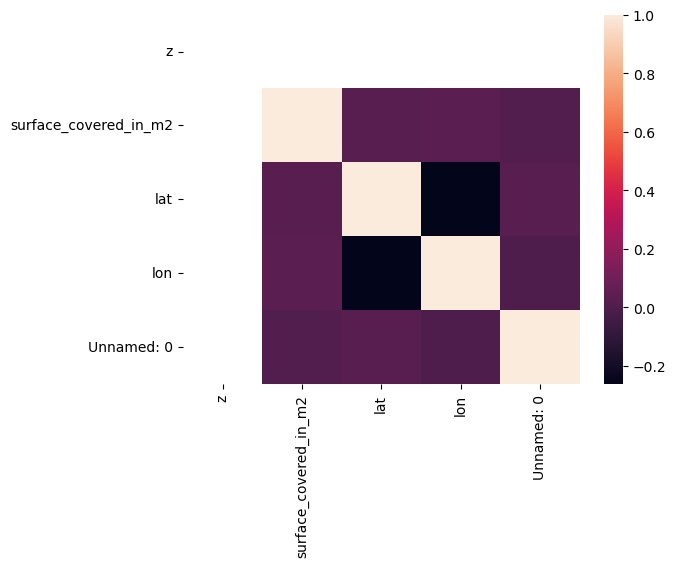

In [11]:

#Finally, the last issue we need to keep an eye out for is **multicollinearity**, that is, features in our feature matrix that are highly correlated with each other. 
#A good way to detect this is to use a heatmap. Let's make one!


#we solve the problem of muticollinearty using heat map. multi is not a problem if we are only concern with performance matrics such as MEA  or other matricesbut if we are concer with model interpretability or 
#explanability it becomes a problem. when model are correlated we dont know if our cofficient  is from this or that or from the correlation of the two, its becomes a problem.

corr = df.select_dtypes("number").drop(columns="price_aprox_usd").corr()
sns.heatmap(corr)

# we have to drop our prce since is our target


# we can use this code for check corr = df.select_dtypes("number").drop(columns="price_aprox_usd").corr()

In [74]:
#"surface_total_in_m2","rooms"surface_covered_in_m2 are all correlated but because surface_covered_in_m2 has less missing number we drop the remaing two

In [12]:
#train


features = ["surface_covered_in_m2", "lat", "lon","neighborhood",]
X_train = df[features]
X_train.shape




target = "price_aprox_usd"
y_train = df[target]
y_train.shape


(6582,)

In [14]:
#build baseline
#Task 2.4.12: Create a pipeline named model that contains a OneHotEncoder, SimpleImputer, and Ridge predictor.

y_mean= y_train.mean()
y_pred_baseline=[y_mean]*len(y_train)
print("Mean apt price:", round(y_mean,2))

print("Baseline MAE:",mean_absolute_error(y_train, y_pred_baseline))

Mean apt price: 132383.84
Baseline MAE: 44860.10834274133


In [15]:
#Task 2.4.12: Create a pipeline named model that contains a OneHotEncoder, SimpleImputer, and Ridge predictor


model = make_pipeline(
      OneHotEncoder(use_cat_names= True),
    SimpleImputer(),
      Ridge()
    
)
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['neighborhood'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

In [78]:
y_pred_training= model.predict(X_train)
print("Training MAE:", mean_absolute_error(y_train, y_pred_training))

Training MAE: 24207.10719033024


In [79]:
# generalized
X_test = X_test = pd.read_excel(r"C:\Users\User\anaconda3\Lib\site-packages\sklearn\datasets\data\mexico folder\housing-in-buenos-irestestfeautures.xlsx")[features]
y_pred_test = pd.Series(model.predict(X_test))
y_pred_test.head()

0    231122.403569
1    162572.942392
2     68477.949626
3     63521.438989
4    105694.463885
dtype: float64

In [16]:
#Task 2.4.15: Create a function make_prediction that takes four arguments (area, lat, lon, and neighborhood) and returns your model's prediction for an apartment price.


def make_prediction(area, lat, lon, neighborhood):
    data={"surface_covered_in_m2": area,
          "lat": lat,
          "lon" :lon,
          "neighborhood":neighborhood
    }
    df=pd.DataFrame(data, index=[0])
    prediction = model.predict(df). round(2)[0]
    return f"Predicted apartment price: ${prediction}"

In [81]:
make_prediction(110, -34.60, -58.46, "Villa Crespo")

'Predicted apartment price: $250775.11'

In [18]:
interact(
    make_prediction,
    area=IntSlider(
        min=X_train["surface_covered_in_m2"].min(),
        max=X_train["surface_covered_in_m2"].max(),
        value=X_train["surface_covered_in_m2"].mean(),
    ),
    lat=FloatSlider(
        min=X_train["lat"].min(),
        max=X_train["lat"].max(),
        step=0.01,
        value=X_train["lat"].mean(),
    ),
    lon=FloatSlider(
        min=X_train["lon"].min(),
        max=X_train["lon"].max(),
        step=0.01,
        value=X_train["lon"].mean(),
    ),
    neighborhood=Dropdown(options=sorted(X_train["neighborhood"].unique())),
);

interactive(children=(IntSlider(value=53, description='area', max=101, min=30), FloatSlider(value=-34.59890626…